In [1]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283859 sha256=babee5e56f65e24bdddf676c43a1e6788443728d8b893cc56510d350b05eab0c
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [6]:
!wget  "https://img.ltn.com.tw/Upload/ent/page/800/2019/03/03/phpINsHdf.jpg"

--2023-05-07 04:30:08--  https://img.ltn.com.tw/Upload/ent/page/800/2019/03/03/phpINsHdf.jpg
Resolving img.ltn.com.tw (img.ltn.com.tw)... 99.84.252.10, 99.84.252.7, 99.84.252.82, ...
Connecting to img.ltn.com.tw (img.ltn.com.tw)|99.84.252.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56140 (55K) [image/jpeg]
Saving to: ‘phpINsHdf.jpg.2’

phpINsHdf.jpg.2     100%[===================>]  54.82K  --.-KB/s    in 0.02s   

2023-05-07 04:30:08 (2.51 MB/s) - ‘phpINsHdf.jpg.2’ saved [56140/56140]



In [8]:
!wget https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json

--2023-05-07 04:31:46--  https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [text/plain]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.003s  

2023-05-07 04:31:46 (11.0 MB/s) - ‘imagenet_class_index.json’ saved [35363/35363]



In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cpu


In [7]:
img_path = 'phpINsHdf.jpg'
img_pil = Image.open(img_path)

In [9]:
model = models.inception_v3(pretrained=True).eval().to(device)
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}   

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 81.5MB/s]


In [10]:
trans_norm = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

trans_A = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    trans_norm
    ])

trans_B = transforms.Compose([
        transforms.ToTensor(),
        trans_norm
    ])

trans_C = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224)
])

In [11]:
input_tensor = trans_A(img_pil).unsqueeze(0).to(device)
pred_logits = model(input_tensor)
pred_softmax = F.softmax(pred_logits, dim=1)
top_n = pred_softmax.topk(5)
top_n

torch.return_types.topk(
values=tensor([[9.8031e-01, 1.5940e-02, 2.7194e-03, 9.6075e-04, 2.5914e-05]],
       grad_fn=<TopkBackward0>),
indices=tensor([[445, 638, 639, 459, 890]]))

In [20]:
def batch_predict(images):
    batch = torch.stack(tuple(trans_B(i) for i in images), dim=0)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()
test_pred = batch_predict([trans_C(img_pil)])
idx2label[test_pred.squeeze().argmax()]

'bikini'

In [15]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(trans_C(img_pil)), 
                                         batch_predict, # 分类预测函数
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=8000) # LIME生成的邻域图像个数

  0%|          | 0/8000 [00:00<?, ?it/s]

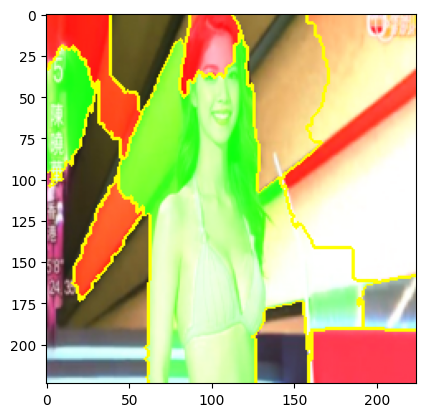

In [21]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=20, hide_rest=False)
img_boundry = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry)
plt.show()

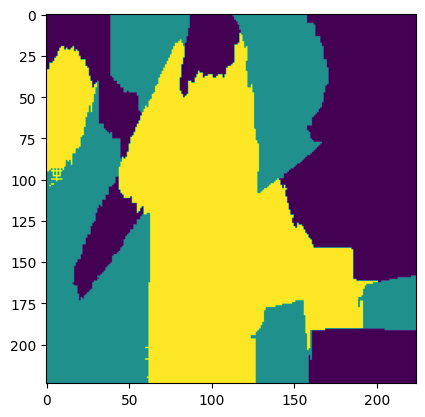

In [22]:
plt.imshow(mask)
plt.show()